# データ水増し用のNotebook

Pytorchの前処理用のモジュールであるtransformsを使用して前処理をする。  
[寺島が作ってくれたtrain.ipynb](https://github.com/mqcmd196/KKB-kaggle/blob/model/bengaliai-cv19/notebooks/train.ipynb)をもとに、その形式で使えるようにデータ水増し用の前処理を実装する。


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd gdrive/My\ Drive/KKB-kaggle/bengaliai-cv19/notebooks

/content/gdrive/My Drive/KKB-kaggle/bengaliai-cv19/notebooks


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchsummary import summary
import gc


dataset_dir = '../dataset'
train_df = pd.read_csv(dataset_dir + '/train.csv')
test_df = pd.read_csv(dataset_dir + '/test.csv')
class_map_df = pd.read_csv(dataset_dir + '/class_map.csv')
sample_sub_df = pd.read_csv(dataset_dir + '/sample_submission.csv')


# データの形状
print(f'Size of training data: {train_df.shape}')
print(f'Size of test data: {test_df.shape}')
print(f'Size of class map: {class_map_df.shape}')


Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [0]:
# 前処理を関数にまとめた

def resize(X, out_height=64, out_width=64):
  print('Resizing raw image... / 前処理実行中…')
  resized = {} # 前処理された画像が格納されるリスト

  for i in tqdm(range(len(X))):
    image = X.iloc[[i]].values.reshape(HEIGHT, WIDTH)
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    left = 1000
    right = -1
    top = 1000
    bottom = -1

    for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      left = min(x, left)
      right = max(x+w, right)
      top = min(y, top)
      bottom = max(y+h, bottom)

    roi = image[top:bottom, left:right]
    resized_roi = cv2.resize(roi, (out_height, out_width),interpolation=cv2.INTER_AREA)
    resized[i] = resized_roi.reshape(-1)

  # print(len(resized))
  
  return resized

In [0]:
# PyTorch式のデータセットクラスを定義

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, Y, transform=None):
        self.transform = transform
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        out_data = self.X[idx].reshape(1,64,64)
        out_data = torch.tensor(out_data, dtype=torch.float)

        #root_label = torch.tensor(self.Y[0][idx], dtype=torch.long)
        #vowel_label = torch.tensor(self.Y[1][idx], dtype=torch.long)
        #cons_label = torch.tensor(self.Y[2][idx], dtype=torch.long)

        root_label = torch.tensor(np.argmax(self.Y[0][idx]), dtype=torch.long)
        vowel_label = torch.tensor(np.argmax(self.Y[1][idx]), dtype=torch.long)
        cons_label = torch.tensor(np.argmax(self.Y[2][idx]), dtype=torch.long)

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, root_label, vowel_label, cons_label
    

In [6]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.b1 = nn.BatchNorm2d(32, momentum=0.15)     
        self.pool = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(32, 32, 5, padding=2)
        self.conv5_dropout = nn.Dropout(p=0.3)

        self.conv6 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv9 = nn.Conv2d(64, 64, 3, padding=1)
        self.b2 = nn.BatchNorm2d(64, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv10 = nn.Conv2d(64, 64, 5, padding=2)
        self.b3 = nn.BatchNorm2d(64, momentum=0.15)
        self.conv10_dropout = nn.Dropout(p=0.3)

        self.conv11 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv12 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv13 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.b4 = nn.BatchNorm2d(128, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv15 = nn.Conv2d(128, 128, 5, padding=2)
        self.b5 = nn.BatchNorm2d(128, momentum=0.15)
        self.conv15_dropout = nn.Dropout(p=0.3)

        self.conv16 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv17 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv18 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv19 = nn.Conv2d(256, 256, 3, padding=1)
        self.b6 = nn.BatchNorm2d(256, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv20 = nn.Conv2d(256, 256, 5, padding=2)
        self.b7 = nn.BatchNorm2d(256, momentum=0.15)
        self.conv20_dropout = nn.Dropout(p=0.3)

        self.dense1 = nn.Linear(256*4*4, 1024)
        self.dense1_dropout = nn.Dropout(p=0.3) # +relu
        self.dense2 = nn.Linear(1024, 512) # +relu

        self.head_root = nn.Linear(512, 168) # + softmax
        self.head_vowel = nn.Linear(512, 11) # + softmax
        self.head_consonant = nn.Linear(512, 7) # + softmax

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.b1(self.conv4(x))))
        x = F.relu(self.conv5(x))
        x = self.conv5_dropout(x)
        
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(F.relu(self.b2(self.conv9(x))))
        x = F.relu(self.b3(self.conv10(x)))
        x = self.conv10_dropout(x)

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool(F.relu(self.b4(self.conv14(x))))
        x = F.relu(self.b5(self.conv15(x)))
        x = self.conv15_dropout(x)

        x = F.relu(self.conv16(x))
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        x = self.pool(F.relu(self.b6(self.conv19(x))))
        x = F.relu(self.b7(self.conv20(x)))
        x = self.conv20_dropout(x)

        x = x.view(-1, 256*4*4)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        
        head_root = self.head_root(x)
        head_vowel = self.head_vowel(x)
        head_consonant = self.head_consonant(x)

        return head_root, head_vowel, head_consonant # not sure..

model = model()
model = try_gpu(model)

criterion1 = nn.CrossEntropyLoss() 
criterion2 = nn.CrossEntropyLoss() 
criterion3 = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters())

summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
            Conv2d-2           [-1, 32, 64, 64]           9,248
            Conv2d-3           [-1, 32, 64, 64]           9,248
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          25,632
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
           Conv2d-10           [-1, 64, 32, 32]          36,928
           Conv2d-11           [-1, 64, 32, 32]          36,928
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        MaxPool2d-14           [-1, 64,

In [0]:
# このセルはあとで変える
def train(model, epoch, train_loader):
    model.train()
    print(f'Epoch number {epoch}')
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, root_l, vowel_l, consonant_l = data
        inputs, root_l, vowel_l, consonant_l = Variable(inputs), Variable(root_l), Variable(vowel_l), Variable(consonant_l)
        inputs, root_l, vowel_l, consonant_l = try_gpu(inputs), try_gpu(root_l), try_gpu(vowel_l), try_gpu(consonant_l)
        optimizer.zero_grad()
        root_o, vowel_o, consonant_o = model(inputs)
        loss1 = criterion1(root_o, root_l)
        loss2 = criterion1(vowel_o, vowel_l)
        loss3 = criterion1(consonant_o, consonant_l)
        (loss1+loss2+loss3).backward()
        optimizer.step()
        # if i % 500 == 0:
        #     print("epoch{} root {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss1.data))
        #     print("epoch{} vowel {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss2.data))
        #     print("epoch{} consonant {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss3.data))

def test(model, test_loader):
    model.eval()
    correct_r, correct_v, correct_c = 0, 0, 0
    total_r, total_v, total_c = 0, 0, 0
    for data in test_loader:
        inputs, root_l, vowel_l, consonant_l = data
        inputs, root_l, vowel_l, consonant_l = Variable(inputs), Variable(root_l), Variable(vowel_l), Variable(consonant_l)
        inputs, root_l, vowel_l, consonant_l = try_gpu(inputs), try_gpu(root_l), try_gpu(vowel_l), try_gpu(consonant_l)
        
        root_o, vowel_o, consonant_o = model(inputs)
        root_pred, vowel_pred, consonant_pred = torch.max(root_o.data,1)[1], torch.max(vowel_o.data,1)[1], torch.max(consonant_o.data,1)[1]
        total_r += root_l.size(0)
        correct_r += (root_pred == root_l).sum()
        total_v += vowel_l.size(0)
        correct_v += (vowel_pred == vowel_l).sum()
        total_c += consonant_l.size(0)
        correct_c += (consonant_pred == consonant_l).sum()

    print("root Accuracy {}/{} {:.2f}%".format(correct_r, total_r, 100.0*correct_r/total_r))
    print("vowel Accuracy {}/{} {:.2f}%".format(correct_v, total_v, 100.0*correct_v/total_v))
    print("consonant Accuracy {}/{} {:.2f}%".format(correct_c, total_c, 100.0*correct_c/total_c))
 

## データ水増し

まずはデータの用意。最初のパケットの画像の最初のミニバッチの画像（型はtensor）を使ってtransformsに標準で実装されている前処理にどんな効果があるのかを試す。  
基本的に画像系の前処理は、PILのimageにしてから変換をするみたい。  

https://pytorch.org/docs/stable/torchvision/transforms.html#conversion-transforms
公式のドキュメント

In [8]:
val_perc = 0.2  # validation set の割合（クロスバリデーション）
epochs = 2

parq_i=0
print('=============================')
print(f'Parquet {parq_i} の訓練を開始')

train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + f'/train_image_data_{parq_i}.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)

HEIGHT = 137
WIDTH = 236

X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])

X_train_resized = pd.DataFrame(resize(X_train)).T / 255.0   # 値を0~1におさめる
X_train_resized = X_train_resized.values

# メモリ節約
del X_train

# PyTorchのデータセットクラスを作る前に、ラベルの情報も整備
# 1-of-K符号化とか、One Hot Encodingとか呼ばれる方法でラベルをつくる

# 注：　PyTorchでは、ラベルはOne Hotじゃなくて良いことが判明したので、結局 MyDataset で元のラベルに戻している

Y_train_root = pd.get_dummies(train_df_with_img['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_df_with_img['vowel_diacritic']).values
Y_train_cons = pd.get_dummies(train_df_with_img['consonant_diacritic']).values

Y_train = [Y_train_root, Y_train_vowel, Y_train_cons]

trainval_dataset = MyDataset(X_train_resized, Y_train)

n_samples = len(trainval_dataset)
train_size = int(len(trainval_dataset)*(1.0 - val_perc))
val_size = n_samples - train_size
print(f'train size: {train_size}, validation size: {val_size}')

train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset,
                        batch_size=32, shuffle=True, num_workers=4)

Parquet 0 の訓練を開始
Resizing raw image... / 前処理実行中…



train size: 40168, validation size: 10042


In [0]:
first_pics = iter(train_loader).next()[0]

In [0]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

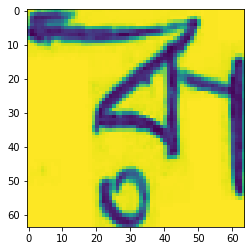

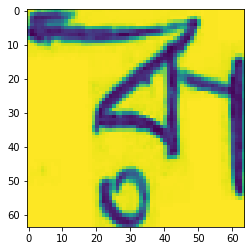

In [11]:
# RandomResizedCrop

unloader = transforms.ToPILImage()  # reconvert into PIL image
random_resized_crop = transforms.RandomResizedCrop((64,64),scale=(0.9,1))

plt.ion()

img = unloader(first_pics[0])

t_img = random_resized_crop(img) # 入力画像をランダムな位置で取り出して拡大とかをする

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)

totorch = transforms.ToTensor()


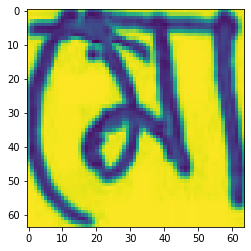

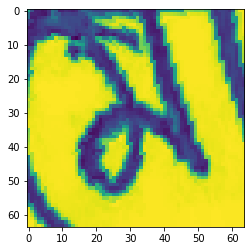

In [12]:
# RandomAffine

unloader = transforms.ToPILImage()  # reconvert into PIL image
random_affine = transforms.RandomAffine((-15,15),scale=(1.15,1.175),fillcolor=1) #fillcolorは上手くできてない。

plt.ion()

img = unloader(first_pics[1])

t_img = random_affine(img) # 入力画像をアフィン変換する。
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)



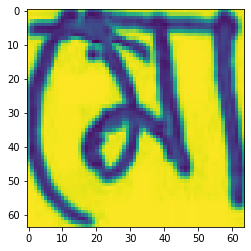

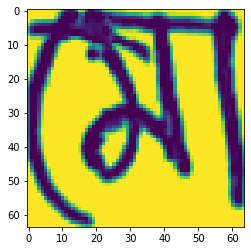

In [13]:
# ColorJitter Randomly change the brightness, contrast and saturation of an image.

unloader = transforms.ToPILImage()  # reconvert into PIL image
colorjitter = transforms.ColorJitter(brightness=(0.1,1.4), contrast=(0.1,1.4), saturation=0, hue=0)

plt.ion()

img = unloader(first_pics[1])
# img = Image.open(first_pics[0]) # 入力画像

t_img = colorjitter(img) # 入力画像を指定サイズで真ん中を切り出す
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)


tensor([[[0.1137, 0.1020, 0.0863,  ..., 0.1216, 0.1216, 0.1216],
         [0.0627, 0.0392, 0.0314,  ..., 0.1216, 0.1216, 0.1216],
         [0.0275, 0.0157, 0.0157,  ..., 0.1216, 0.1216, 0.1216],
         ...,
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216]]])


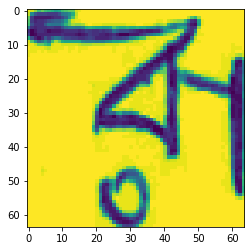

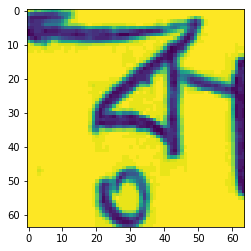

In [16]:
# RandomChoice(transforms, p=0.5) 輝度変えるのと上の２つをランダムに選んで一つ適応する。

unloader = transforms.ToPILImage()  # reconvert into PIL image
colorjitter = transforms.ColorJitter(brightness=(0.1,1.4), contrast=(0.1,1.4), saturation=0, hue=0)
random_resized_crop = transforms.RandomResizedCrop((64,64),scale=(0.95,1))
random_affine = transforms.RandomAffine((-15,15),scale=(1.15,1.175),fillcolor=1) #fillcolorは上手くできてない。
random_choice = transforms.RandomChoice([random_resized_crop,random_affine])

plt.ion()

img = unloader(first_pics[0])

img = colorjitter(img) #入力画像の輝度とかをランダムに変える
t_img = random_choice(img) # 入力画像をランダムに切り出すか、アフィン変換

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)

totorch = transforms.ToTensor()
print(totorch(t_img))

使えそうだったものを適応してみる。  
MyDatasetに引数として以下のように。

In [0]:
#このようにする
from torchvision import transforms

random_resized_crop = transforms.RandomResizedCrop((64,64),scale=(0.95,1))
random_affine = transforms.RandomAffine((-15,15),scale=(1.15,1.175),fillcolor=1) #fillcolorは上手くできてない。

trainval_dataset = MyDataset(X_train_resized, Y_train ,transform=transforms.Compose([
                                                                                     transforms.ToPILImage(),
                                                                                     transforms.ColorJitter(brightness=(0.1,1.4), contrast=(0.1,1.4), saturation=0, hue=0),
                                                                                     transforms.RandomChoice([random_resized_crop,random_affine]),
                                                                                     transforms.ToTensor()
]))

In [0]:
del train_df_with_img
del train_dataset
del train_loader
gc.collect()

これでできるか試してみる

In [0]:
# 訓練ループ / Training Loop

val_perc = 0.2  # validation set の割合（クロスバリデーション）
epochs = 2

for parq_i in range(4):
  print('=============================')
  print(f'Parquet {parq_i} の訓練を開始')

  train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + f'/train_image_data_{parq_i}.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)

  HEIGHT = 137
  WIDTH = 236

  X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])

  X_train_resized = pd.DataFrame(resize(X_train)).T / 255.0   # 値を0~1におさめる
  X_train_resized = X_train_resized.values

  # メモリ節約
  del X_train

  # PyTorchのデータセットクラスを作る前に、ラベルの情報も整備
  # 1-of-K符号化とか、One Hot Encodingとか呼ばれる方法でラベルをつくる

  # 注：　PyTorchでは、ラベルはOne Hotじゃなくて良いことが判明したので、結局 MyDataset で元のラベルに戻している

  Y_train_root = pd.get_dummies(train_df_with_img['grapheme_root']).values
  Y_train_vowel = pd.get_dummies(train_df_with_img['vowel_diacritic']).values
  Y_train_cons = pd.get_dummies(train_df_with_img['consonant_diacritic']).values

  Y_train = [Y_train_root, Y_train_vowel, Y_train_cons]

  # transformsを使ったデータ水増し的なデータの前処理--------------------------------------------------------------------------------------------------------------------------
  random_resized_crop = transforms.RandomResizedCrop((64,64),scale=(0.95,1))
  random_affine = transforms.RandomAffine((-15,15),scale=(1.15,1.175),fillcolor=1) #fillcolorは上手くできてない。

  trainval_dataset = MyDataset(X_train_resized, Y_train ,transform=transforms.Compose([
                                                                                       transforms.ToPILImage(),
                                                                                       transforms.ColorJitter(brightness=(0.1,1.4), contrast=(0.1,1.4), saturation=0, hue=0),
                                                                                       transforms.RandomChoice([random_resized_crop,random_affine]),
                                                                                       transforms.ToTensor()
  ]))
  # trainval_dataset = MyDataset(X_train_resized, Y_train)
  #--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

  n_samples = len(trainval_dataset)
  train_size = int(len(trainval_dataset)*(1.0 - val_perc))
  val_size = n_samples - train_size
  print(f'train size: {train_size}, validation size: {val_size}')

  train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32, shuffle=True, num_workers=4)
  val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=0)
  
  for i in range(1,epochs+1):
    train(model, i, train_loader)
    test(model, val_loader)

  # メモリ節約
  del train_df_with_img
  del train_dataset
  del train_loader
  gc.collect()

Parquet 0 の訓練を開始
Resizing raw image... / 前処理実行中…



train size: 40168, validation size: 10042
Epoch number 1



root Accuracy 309/10042 3.08%
vowel Accuracy 3567/10042 35.52%
consonant Accuracy 6285/10042 62.59%
Epoch number 2



root Accuracy 584/10042 5.82%
vowel Accuracy 6412/10042 63.85%
consonant Accuracy 6851/10042 68.22%
Parquet 1 の訓練を開始
Resizing raw image... / 前処理実行中…


### 今回は使ってないけど試したやつ。

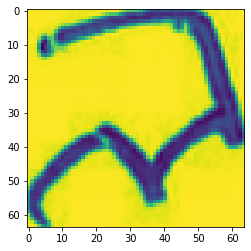

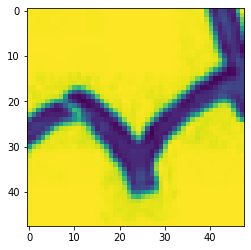

In [53]:
# RandomCrop

unloader = transforms.ToPILImage()  # reconvert into PIL image
trans_crop = transforms.RandomCrop((48,48))

plt.ion()

img = unloader(first_pics[0])
# img = Image.open(first_pics[0]) # 入力画像

t_img = trans_crop(img) # 入力画像をランダムクロップ、ランダムな位置で取り出す

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)

totorch = transforms.ToTensor()


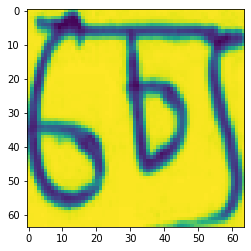

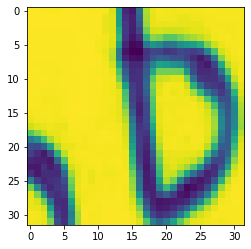

In [48]:
# CenterCrop

unloader = transforms.ToPILImage()  # reconvert into PIL image
trans_crop = transforms.CenterCrop((32,32))

plt.ion()

img = unloader(first_pics[1])
# img = Image.open(first_pics[0]) # 入力画像

t_img = trans_crop(img) # 入力画像を指定サイズで真ん中を切り出す
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)


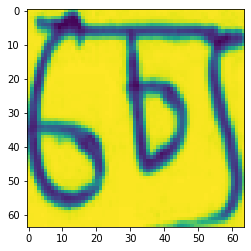

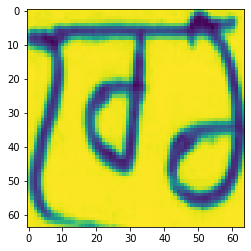

In [49]:
# RandomHorizontalFlip

unloader = transforms.ToPILImage()  # reconvert into PIL image
trans = transforms.RandomHorizontalFlip(1)

plt.ion()

img = unloader(first_pics[1])
# img = Image.open(first_pics[0]) # 入力画像

t_img = trans(img) # 入力画像を指定サイズで真ん中を切り出す
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)


tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9765, 0.9961, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 0.9843, 0.9882, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9882, 1.0000],
         ...,
         [0.9373, 0.6980, 0.3451,  ..., 1.0000, 1.0000, 1.0000],
         [0.9765, 0.9216, 0.7176,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 0.9608,  ..., 1.0000, 1.0000, 1.0000]]])


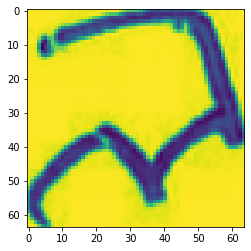

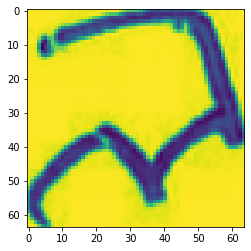

In [182]:
# RandomApply(transforms, p=0.5) ２つの変換をそれぞれ確率pで適応する

unloader = transforms.ToPILImage()  # reconvert into PIL image
random_resized_crop = transforms.RandomResizedCrop((64,64),scale=(0.95,1))
random_affine = transforms.RandomAffine((-15,15),scale=(1.15,1.175),fillcolor=1) #fillcolorは上手くできてない。
random_apply = transforms.RandomApply([random_resized_crop,random_affine],p=0.5)

plt.ion()

img = unloader(first_pics[0])

t_img = random_apply(img) # 入力画像をランダムな位置で取り出して拡大とかをする

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(t_img)

totorch = transforms.ToTensor()
print(totorch(t_img))